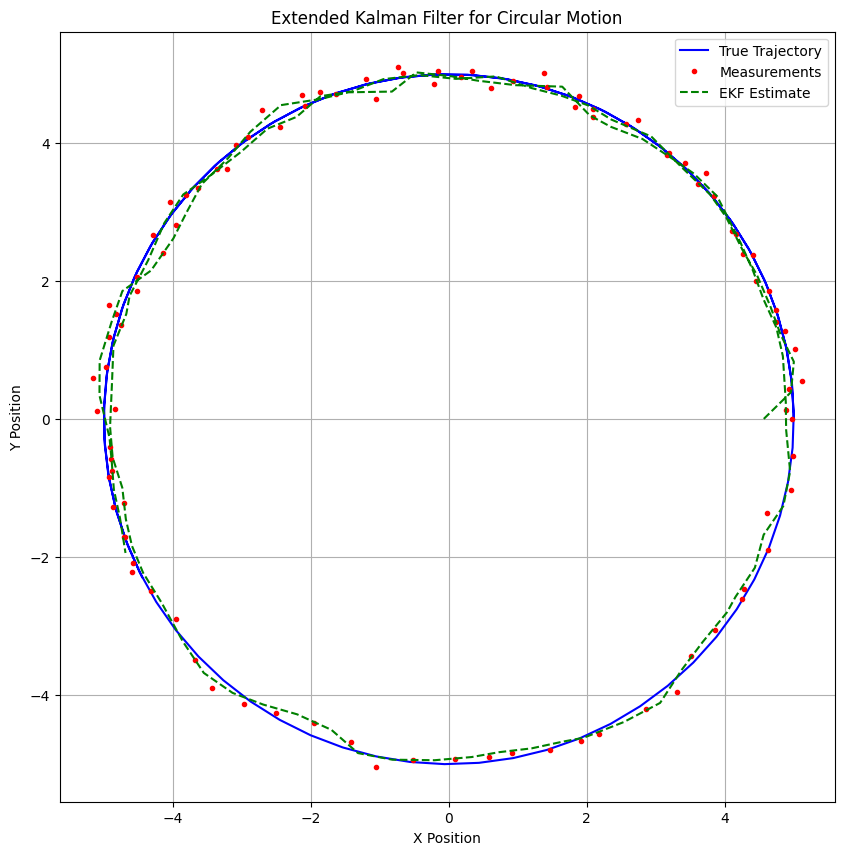

MSE of raw measurements: 0.0099
MSE of EKF estimates: 0.0448


In [1]:
import numpy as np
import matplotlib.pyplot as plt

class ExtendedKalmanFilter:
    def __init__(self, f, h, Q, R, P, x0):
        self.f = f  # нелинейная функция перехода состояния
        self.h = h  # нелинейная функция измерения
        self.Q = Q  # ковариация шума процесса
        self.R = R  # ковариация шума измерения
        self.P = P  # начальная ковариация ошибки
        self.x = x0 # начальное состояние

    def predict(self, u=0):
        self.x = self.f(self.x, u)
        F = self.jacobian_f(self.x, u)
        self.P = np.dot(np.dot(F, self.P), F.T) + self.Q
        return self.x

    def update(self, z):
        H = self.jacobian_h(self.x)
        y = z - self.h(self.x)
        S = np.dot(np.dot(H, self.P), H.T) + self.R
        K = np.dot(np.dot(self.P, H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(len(self.x))
        self.P = np.dot((I - np.dot(K, H)), self.P)
        return self.x

    def jacobian_f(self, x, u):
        # Вычисление якобиана функции f
        return np.array([[1, 0, -u*np.sin(x[2]), u*np.cos(x[2])],
                         [0, 1, u*np.cos(x[2]), u*np.sin(x[2])],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]])

    def jacobian_h(self, x):
        # Вычисление якобиана функции h
        return np.array([[1, 0, 0, 0],
                         [0, 1, 0, 0]])

# Определение нелинейных функций модели
def f(x, u):
    # x = [x, y, theta, v]
    return np.array([x[0] + u*np.cos(x[2]),
                     x[1] + u*np.sin(x[2]),
                     x[2] + u/0.1,
                     x[3]])

def h(x):
    return np.array([x[0], x[1]])

# Параметры модели
Q = np.eye(4) * 0.1
R = np.eye(2) * 0.1
P = np.eye(4)
x0 = np.array([0, 0, 0, 1])

# Создаем EKF
ekf = ExtendedKalmanFilter(f, h, Q, R, P, x0)

# Генерируем данные и применяем фильтр
true_states = []
measurements = []
estimated_states = []

time_steps = 100
dt = 0.1
radius = 5

for t in range(time_steps):
    # Истинное состояние (движение по кругу)
    theta = t * dt
    true_state = np.array([radius * np.cos(theta),
                           radius * np.sin(theta),
                           theta + np.pi/2,
                           radius * dt])

    # Генерируем зашумленное измерение
    measurement = h(true_state) + np.random.normal(0, 0.1, 2)

    # Применяем EKF
    ekf.predict(u=dt)
    estimated_state = ekf.update(measurement)

    true_states.append(true_state[:2])
    measurements.append(measurement)
    estimated_states.append(estimated_state[:2])

# Преобразуем списки в массивы numpy для удобства
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

# Визуализация результатов
plt.figure(figsize=(10, 10))
plt.plot(true_states[:, 0], true_states[:, 1], 'b-', label='True Trajectory')
plt.plot(measurements[:, 0], measurements[:, 1], 'r.', label='Measurements')
plt.plot(estimated_states[:, 0], estimated_states[:, 1], 'g--', label='EKF Estimate')
plt.legend()
plt.title('Extended Kalman Filter for Circular Motion')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.grid(True)
plt.show()

# Анализ ошибки
mse_measurements = np.mean((measurements - true_states[:, :2])**2)
mse_ekf = np.mean((estimated_states - true_states[:, :2])**2)

print(f"MSE of raw measurements: {mse_measurements:.4f}")
print(f"MSE of EKF estimates: {mse_ekf:.4f}")